In [3]:
import os
import pandas as pd

os.chdir(r'C:\Users\pc\Documents\kaggle\final2')

In [4]:
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
lb = pd.read_csv("loan_before.csv")

In [5]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [6]:
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

#  1.문제정의

<strong>질문1</strong> - 대출 상환에 영향을 크게 미치는 요소들은? (절대적인 크기) <br>
<strong>질문2</strong> - 그 요소들은 어떤 형태로 영향을 줄까?

# 2. 방법론

## 2.1 분석과정 <br>
    해석가능한 머신러닝(xAI)을 활용해보자

<strong> 프로세스</strong>

1단계 : feature engineering <br>
2단계 : 머신러닝 모델링<br>
3단계 : shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아보자<br>
4단계 : 영향력을 많이 주는 상위 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다.

# feature engineering

In [7]:
train.head() 

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,-2256,NaN,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,-4133,NaN,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,-4340,NaN,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,-1621,12.0,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,-2870,NaN,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0


In [8]:
train['AMT_CREDIT_TO_ANNUITY_RATIO']=train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO']=test['AMT_CREDIT']/test['AMT_ANNUITY']

In [9]:
lb.head()

,SK_ID_CURR,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,CREDIT_TYPE
0,400486,-2413,0,180000.0,Consumer credit
1,400486,-941,0,40500.0,Credit card
2,400486,-1110,0,114727.5,Consumer credit
3,400486,-2133,0,225000.0,Consumer credit
4,400486,-391,0,142290.0,Consumer credit


In [14]:
lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index()

,SK_ID_CURR,AMT_CREDIT_SUM
0,100026,1.875000e+06
1,100041,6.325424e+04
2,100084,9.810000e+04
3,100088,3.555000e+05
4,100100,6.327487e+05
...,...,...
25707,456153,1.627073e+05
25708,456212,2.726224e+05
25709,456238,1.849170e+05
25710,456253,9.900000e+05


In [50]:
train=pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on = 'SK_ID_CURR', how='left')
test=pd.merge(test, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on = 'SK_ID_CURR', how='left')
train=pd.merge(train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on = 'SK_ID_CURR', how='left')
test=pd.merge(test, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on = 'SK_ID_CURR', how='left')
train=pd.merge(train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on = 'SK_ID_CURR', how='left')
test=pd.merge(test, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on = 'SK_ID_CURR', how='left')

In [47]:
lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0 : "count"})
lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].std().reset_index().rename(columns={"AMT_CREDIT_SUM" : "AMT_CREDIT_SUM_STD"})

,SK_ID_CURR,AMT_CREDIT_SUM_STD
0,100026,723273.807074
1,100041,49999.349559
2,100084,NaN
3,100088,240444.900133
4,100100,851484.141996
...,...,...
25707,456153,215480.596546
25708,456212,340917.745743
25709,456238,259511.195700
25710,456253,853024.032487


In [51]:
train=pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].std().reset_index().rename(columns={"AMT_CREDIT_SUM" : "AMT_CREDIT_SUM_STD"}), on = 'SK_ID_CURR', how='left')
test=pd.merge(test, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].std().reset_index().rename(columns={"AMT_CREDIT_SUM" : "AMT_CREDIT_SUM_STD"}), on = 'SK_ID_CURR', how='left')
train=pd.merge(train, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0 : "count"}), on = 'SK_ID_CURR', how='left')
test=pd.merge(test, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0 : "count"}), on = 'SK_ID_CURR', how='left')

In [52]:
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_STD,count
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,0.665732,NaN,-139.0,1.0,21.327469,3.150000e+05,-36.000000,0.0,NaN,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,0.535140,0.670652,-957.0,0.0,19.378955,2.067966e+06,-1408.000000,0.0,2.682085e+06,9.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,0.002272,0.154744,-827.0,1.0,9.523966,6.219386e+04,-597.142857,0.0,6.350477e+04,7.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,0.120444,NaN,-569.0,2.0,20.000000,2.770443e+04,-1545.000000,0.0,NaN,1.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,0.722415,0.723837,-1544.0,4.0,26.260504,1.068750e+05,-2696.000000,0.0,NaN,1.0


In [54]:
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
CODE_GENDER                    float64
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
ORGANIZATION_TYPE               object
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEA

In [55]:
###변수제거 필요
## 샵벨류로 범주형 변수를 설명하기 어렵다.
## code_gender 처럼 int이지만 실질적으로는 범주형 자료인 것들도 설명을 위해 제거할 필요가 있다.
del_list=['CODE_GENDER','FLAG_OWN_CAR','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE',
          'ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
##외부데이터의 경우 설명이 불가능하므로 이번에는 제외

In [56]:
##axis = 0 하면 행을 없애버리니 주의
train = train.drop(del_list,axis=1)
test = test.drop(del_list,axis=1)

In [57]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM_STD', 'count'],
      dtype='object')

<strong> 큰제목 </strong>
<ul>
    <li>소제목1 : 제목</li>
    <li>소제목2 : 제목</li>
    <li>소제목3 : 제목</li>
</ul>

# 모델링

## input간 상관성 체크

In [58]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM_STD', 'count']

In [63]:
corr=train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_STD,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.000012,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.055898,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.275856,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.142873,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.145675,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,0.086207,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,0.093794,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.017087,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,0.029026,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.081863,-0.025711


<ul>
    <li>AMT_CREDIT_SUM ,AMT_CREDIT_SUM_STD</li>
    <li>CNT_FAM_MEMBERS, CNT_CHILDREN</li>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO , AMT_CREDIT</li>
    <li>AMT_ANNUITY, AMT_CREDIT</li>
</ul>

In [65]:
## 위에서 하나씩 제거해야함
## 어떤 것을 뺼지는 target값과 상관계수로 판단
## corr은 선형관계만 이지만은...
train['CNT_FAM_MEMBERS'].corr(train['TARGET'])

0.018876651698723705

In [66]:
train['CNT_CHILDREN'].corr(train['TARGET'])

0.025357359317615676

In [69]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [67]:
train['AMT_CREDIT_SUM'].corr(train['TARGET'])

-0.023206944767953198

In [68]:
train['AMT_CREDIT_SUM_STD'].corr(train['TARGET'])

-0.01842270543416455

In [70]:
del train['AMT_CREDIT_SUM_STD']
del test['AMT_CREDIT_SUM_STD']

In [71]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [72]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [73]:
input_var=['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [ ]:
### shap value를 쓸려면 tree형 모델을 사용해야해

In [74]:
from xgboost import XGBClassifier

In [77]:
model = XGBClassifier(n_estimators=100, learning_rate = 0.1)
model.fit(train[input_var],train['TARGET'])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

# shap value

In [78]:
import shap

In [81]:
shap_values=shap.TreeExplainer(model).shap_values(train[input_var])

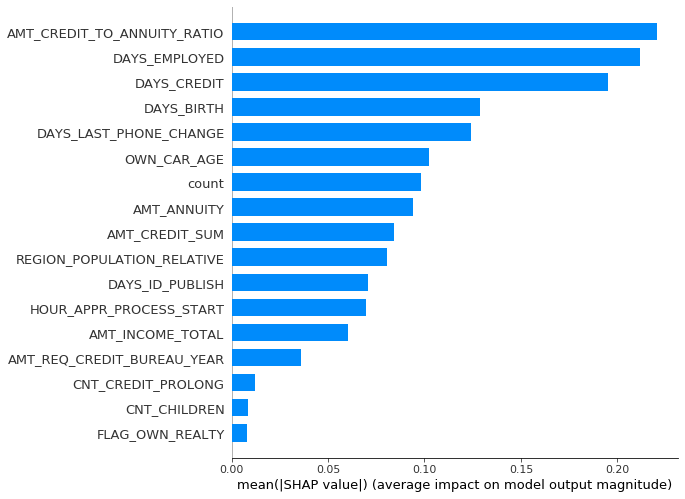

In [83]:
shap.summary_plot(shap_values, train[input_var],plot_type='bar')

# 상위 5개 변수

In [84]:
input_var

['FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'HOUR_APPR_PROCESS_START',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_CREDIT_TO_ANNUITY_RATIO',
 'AMT_CREDIT_SUM',
 'DAYS_CREDIT',
 'CNT_CREDIT_PROLONG',
 'count']

### AMT_CREDIT_TO_ANNUITY_RATIO

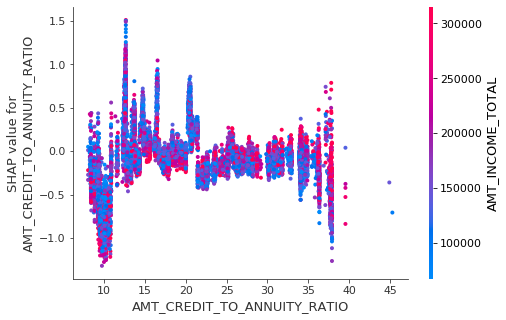

In [85]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values,train[input_var])

### DAYS_EMPLOYED

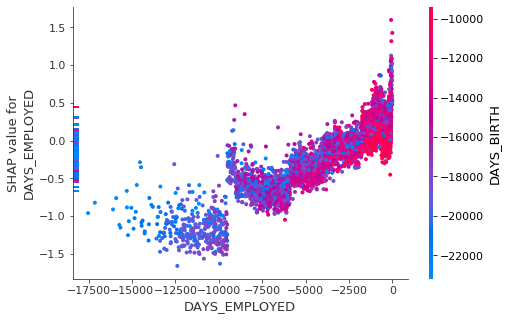

In [86]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values,train[input_var])

### DAYS_CREDIT

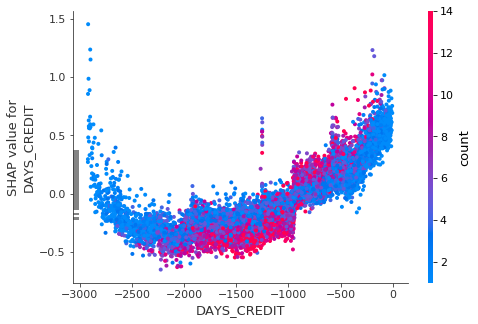

In [87]:
shap.dependence_plot('DAYS_CREDIT', shap_values,train[input_var])

### DAYS_BIRTH

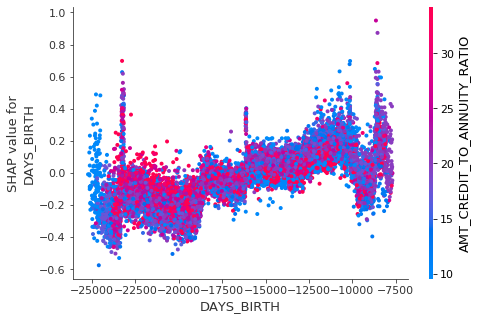

In [88]:
shap.dependence_plot('DAYS_BIRTH', shap_values,train[input_var])

### DAYS_LAST_PHONE_CHANGE

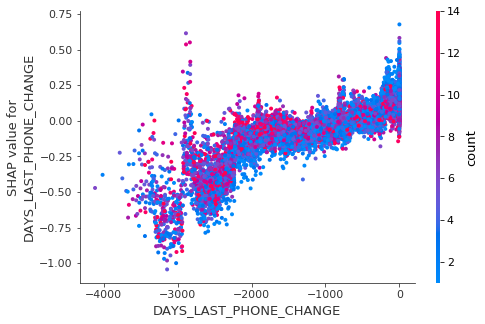

In [89]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values,train[input_var])

### OWN_CAR_AGE

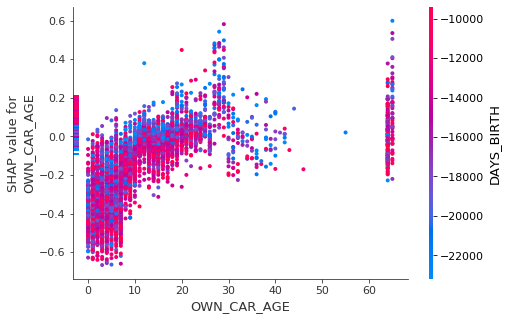

In [90]:
shap.dependence_plot('OWN_CAR_AGE', shap_values,train[input_var])

### count

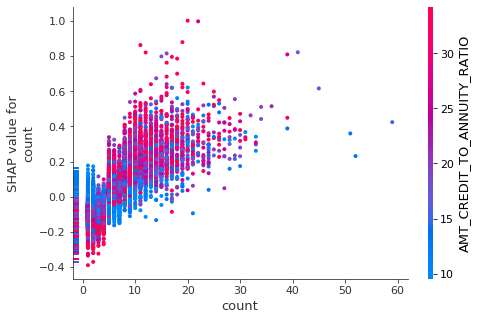

In [91]:
shap.dependence_plot('count', shap_values,train[input_var])

# 마무리 시각화

In [98]:
group1 =train.loc[(train['DAYS_EMPLOYED'].quantile(0.75)<train['DAYS_EMPLOYED'])&
         (train['AMT_CREDIT_TO_ANNUITY_RATIO'].quantile(0.5)<train['AMT_CREDIT_TO_ANNUITY_RATIO'])&
         (train['DAYS_CREDIT'].quantile(0.75)<train['DAYS_CREDIT'])&
         (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)<train['DAYS_LAST_PHONE_CHANGE'])&
         (train['count'].quantile(0.5)<train['count'])&
         (train['DAYS_BIRTH'].quantile(0.5)<train['DAYS_BIRTH'])]

In [101]:
group2 =train.loc[(train['DAYS_EMPLOYED'].quantile(0.25)>train['DAYS_EMPLOYED'])&
         (train['AMT_CREDIT_TO_ANNUITY_RATIO'].quantile(0.5)>train['AMT_CREDIT_TO_ANNUITY_RATIO'])&
         (train['DAYS_CREDIT'].quantile(0.25)>train['DAYS_CREDIT'])&
         (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)>train['DAYS_LAST_PHONE_CHANGE'])&
         (train['count'].quantile(0.5)>train['count'])&
         (train['DAYS_BIRTH'].quantile(0.5)>train['DAYS_BIRTH'])]

In [102]:
group1['group'] = 1
group2['group'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
full = pd.concat([group1,group2],axis=0)

In [104]:
full

,SK_ID_CURR,TARGET,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count,group
97,449339,0,1,0,139500.0,22122.0,0.018801,-8723,-263.0,-1404,13.0,8,-256.0,1.0,24.410090,402856.500,-449.666667,0.0,6.0,1
455,440170,1,1,0,180000.0,11074.5,0.026392,-8423,-645.0,-1109,NaN,13,0.0,2.0,20.316944,130358.250,-292.666667,0.0,6.0,1
881,232407,0,1,0,135000.0,22018.5,0.026392,-8232,-331.0,-885,NaN,18,0.0,4.0,20.437359,76199.400,-384.200000,0.0,5.0,1
1697,215986,0,0,0,225000.0,38331.0,0.003818,-12350,-130.0,-2205,16.0,7,-1.0,3.0,28.128669,246174.000,-519.333333,0.0,6.0,1
2921,215568,0,1,3,202500.0,38551.5,0.018634,-14933,-224.0,-1461,NaN,15,-2.0,1.0,34.087312,169934.427,-645.100000,0.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18599,420891,0,1,0,162000.0,52452.0,0.006629,-17415,-3222.0,-940,NaN,5,-2447.0,1.0,19.536719,140242.500,-1800.666667,0.0,3.0,0
18892,242937,0,1,0,270000.0,49486.5,0.020246,-18527,-4374.0,-2075,7.0,12,-1673.0,6.0,19.533509,721993.500,-1698.500000,0.0,2.0,0
19574,393858,0,1,0,90000.0,20250.0,0.025164,-19392,-7046.0,-2953,NaN,7,-1963.0,2.0,12.577778,43114.500,-1508.500000,0.0,2.0,0
19708,236135,0,1,0,112500.0,24030.0,0.007274,-17725,-4774.0,-1256,NaN,12,-2266.0,0.0,11.588015,900000.000,-1439.000000,0.0,1.0,0


In [105]:
import seaborn as sns

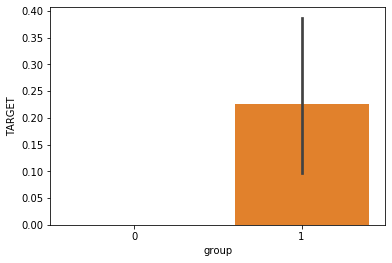

In [106]:
sns.barplot('group','TARGET',data=full)